# Проект: классификация

In [1462]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import plotly
import plotly.express as px

Данные о клиентах банка:
age (возраст);
job (сфера занятости);
marital (семейное положение);
education (уровень образования);
default (имеется ли просроченный кредит);
housing (имеется ли кредит на жильё);
loan (имеется ли кредит на личные нужды);
balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:
contact (тип контакта с клиентом);
month (месяц, в котором был последний контакт);
day (день, в который был последний контакт);
duration (продолжительность контакта в секундах).

Прочие признаки:
campaign (количество контактов с этим клиентом в течение текущей кампании);
pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
previous (количество контактов до текущей кампании)
poutcome (результат прошлой маркетинговой кампании).
И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [1463]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes


In [1464]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
print(df[df['balance'].isnull()]['age'].count(),': количество пропусков в признаке balance')
df.info()

25 : количество пропусков в признаке balance
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [1465]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()
# пропущенное значение именуется unknown

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [1466]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.strip().str.replace('$', '').str.replace(' ', '').str.replace(',00', '')
df['balance'] = df['balance'].astype('float64')
df['balance'].mean().round(3)

1529.129

### Задание 4

In [1467]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())
df['balance'].mean().round(3)

1526.936

### Задание 5

In [1468]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df['job'] = df['job'].replace('unknown', None)
df['job'] = df['job'].fillna(df['job'].mode()[0])

df['education'] = df['education'].replace('unknown', None)
df['education'] = df['education'].fillna(df['education'].mode()[0])

print(df['job'].mode()[0], '- самая популярная профессия')
print(df['education'].mode()[0], '- самое распространенное образование')
mask = (df['job'] == 'management') & (df['education'] == 'secondary')
print(df[mask]['balance'].mean().round(3), '- средний баланс для клиентов с самой популярной профессией и самым распространенным образованием')

management - самая популярная профессия
secondary - самое распространенное образование
1598.883 - средний баланс для клиентов с самой популярной профессией и самым распространенным образованием


### Задание 6

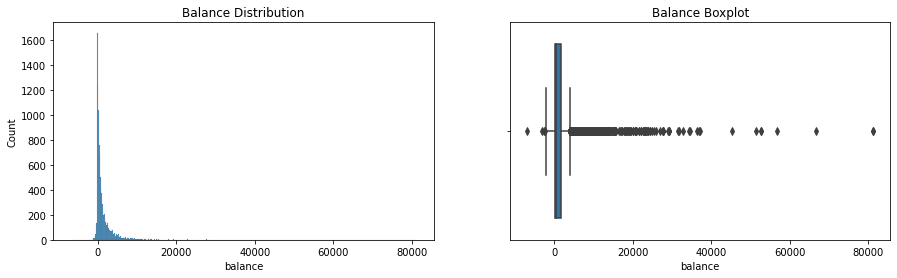

In [1469]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Balance Distribution');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Balance Boxplot');

In [1470]:
#  удалите все выбросы для признака balance
# ваш код
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<=lower_bound) | (x >= upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return lower_bound, upper_bound, outliers, cleaned
lower_bound, upper_bound, outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Нижняя граница по методу Тьюки: {lower_bound}')
print(f'Верхняя граница по методу Тьюки: {upper_bound}')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Нижняя граница по методу Тьюки: -2241.0
Верхняя граница по методу Тьюки: 4063.0
Число выбросов по методу Тьюки: 1058
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

In [1471]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
cleaned['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

In [1472]:
import pandas as pd
from pandas_profiling import ProfileReport
profile = ProfileReport(cleaned, title="Pandas Profiling Report")
# profile
# profile.to_file("cleaned.html")

### Задания 2 и 3

In [1473]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
# Cтатистические и визуальные показатели представлены в pandas_profiling

### Задания 4 и 5

In [1474]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
# Cтатистические и визуальные показатели представлены в pandas_profiling

### Задание 6

In [1475]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
# success, статистические и визуальные показатели представлены в pandas_profiling

### Задание 7

In [1476]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
# may, статистические и визуальные показатели представлены в pandas_profiling

### Задание 8

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,bin_age
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60


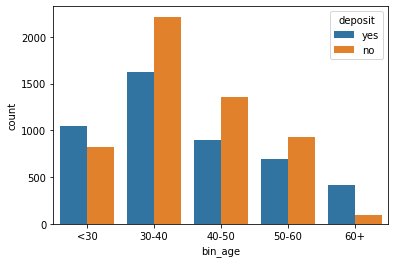

In [1477]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
# def get_age(age):
#     if age < 30:
#         return '<30'
#     elif (age >= 30) & (age < 40):
#         return '30-40'
#     elif (age >= 40) & (age < 50):
#         return '40-50'
#     elif (age >= 50) & (age < 60):
#         return '50-60'
#     return '60+'
# cleaned['bin_age'] = cleaned['age'].apply(get_age)

cleaned['bin_age'] = pd.cut(cleaned.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x='bin_age', hue="deposit", data=cleaned)
cleaned.head(2)

In [1478]:
fig = px.histogram(
    cleaned,
    x='bin_age',
    color = 'deposit',
    width=600,
    height=450)
fig.show()
# Наиболее активные в открытии вкладов в рамках сформированных предложений возрастные группы до 30 лет и 60+


### Задания 9 и 10

In [1479]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig = px.histogram(
    cleaned,
    x='marital',
    color = 'deposit',
    width=500,
    height=400)
fig.show()

In [1480]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig = px.histogram(
    cleaned,
    x='education',
    color = 'deposit',
    width=500,
    height=400)
fig.show()

In [1481]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig = px.histogram(
    cleaned,
    x='job',
    color = 'deposit',
    width=600,
    height=450)
fig.show()

### Задание 11

In [1482]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_deposit = cleaned[cleaned['deposit'] == 'yes']

pivot = df_deposit.pivot_table(
index='marital',
columns='education',
values='deposit',
aggfunc='count',
fill_value=0)

fig = px.imshow(
pivot,
aspect='auto',
color_continuous_scale='reds',
title='Зависимость открытия счетов от образования и семейного положения')
fig.show()
# Наибольшее количество открываемых вкладов прослеживается по клиентам с семейным положением: "married" и образованием "secondary"

## Часть 3: преобразование данных

### Задание 1

In [1483]:
# преобразуйте уровни образования
LE = LabelEncoder()
cleaned['education'] = LE.fit_transform(cleaned['education'])
cleaned['bin_age'] = LE.fit_transform(cleaned['bin_age'])
cleaned.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,bin_age
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1


In [1484]:
cleaned['education'].sum()

11995

### Задания 2 и 3

In [1485]:
# преобразуйте бинарные переменные в представление из нулей и единиц
def bin_func(row):
    if row == 'yes':
        return 1
    return 0

cleaned['deposit'] = cleaned['deposit'].apply(bin_func)
cleaned['default'] = cleaned['default'].apply(bin_func)
cleaned['housing'] = cleaned['housing'].apply(bin_func)
cleaned['loan'] = cleaned['loan'].apply(bin_func)
cleaned.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,bin_age
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1


### Задание 4

In [1486]:
# создайте дамми-переменные
print(cleaned['deposit'].std().round(3))
categorial_features = ['job', 'marital', 'contact', 'month', 'poutcome']
df1= pd.get_dummies(cleaned[categorial_features])
cleaned = pd.concat([cleaned,df1], axis = 1)
cleaned.head(3)

0.499


,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
1,56,admin.,married,1,0,45.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
2,41,technician,married,1,0,1270.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1


### Задания 5 и 6

In [1487]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
res = cleaned['default'].mean() + cleaned['housing'].mean() + cleaned['loan'].mean()
print(res.round(3))

from plotly.offline import iplot
import plotly.figure_factory as ff
corrs = cleaned.corr()

figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)

figure.layout.height = 1000
figure.layout.width = 1600

iplot(figure)

0.635


In [1488]:
new_corr = corrs['deposit'].reset_index()
sort_corr = new_corr.sort_values('deposit', ascending=False)
sort_corr.head()

,index,deposit
11,deposit,1.000000
7,duration,0.457818
44,poutcome_success,0.288491
27,contact_cellular,0.223944
9,pdays,0.147917


### Задания 7 и 8

In [1489]:
cleaned = cleaned.drop(['job', 'marital', 'contact', 'month', 'poutcome'], axis=1)
X = cleaned.drop(['deposit'], axis=1)
y = cleaned['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [1490]:
# рассчитайте необходимые показатели
print(X_test.shape, 'размерность тестовой выборки')
print(y_test.value_counts(True).round(2), 'соотношение целевой переменной')

(3335, 45) размерность тестовой выборки
0    0.54
1    0.46
Name: deposit, dtype: float64 соотношение целевой переменной


### Задание 9

In [1491]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=15)
selector.fit(X_train, y_train)
list(selector.get_feature_names_out())

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'bin_age',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [1492]:
# нормализуйте данные с помощью minmaxsxaler
df = cleaned[['balance', 'housing', 'duration', 'campaign', 'pdays', 
         'previous', 'bin_age', 'contact_cellular', 'contact_unknown',
         'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown', 'deposit']]

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_test_scaled[:, 0].mean().round(2))  # для признака balance

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [1493]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag', random_state=42, max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)
y_train_pred = log_reg.predict(X_train_scaled)

print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = log_reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))
print('Test accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335

Test accuracy: 0.81


In [1494]:
features = (df.drop('deposit', axis=1)).columns
coef = log_reg .coef_
log_reg .coef_

df_features = pd.DataFrame(coef.T, index = features).reset_index().rename(columns={'index': 'Features', 0: 'Coefficients'})
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': log_reg .intercept_})
coef_df = pd.concat([df_features, intercept_df], ignore_index=True)
display(coef_df.sort_values('Coefficients', ascending=False))


,Features,Coefficients
2,duration,16.362921
9,month_mar,2.230607
13,poutcome_success,2.173784
12,month_sep,1.760402
11,month_oct,1.373687
0,balance,1.194602
5,previous,0.775342
6,bin_age,0.617665
7,contact_cellular,0.184036
4,pdays,0.053826


### Задания 2,3,4

In [1495]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)
dt.fit(X_train_scaled, y_train)
y_train_pred = dt.predict(X_train_scaled)

print('Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))

y_test_pred = dt.predict(X_test_scaled)

print('Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train: 0.82
Test: 0.81


### Задание 5

In [1496]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}
model_cv = GridSearchCV(tree.DecisionTreeClassifier(), parameters,
 cv=3, scoring=('f1'), return_train_score=True)
model_cv.fit(X_train_scaled, y_train)

print("Наилучшие значения параметров: {}".format(model_cv.best_params_))

y_test_pred = model_cv.predict(X_test_scaled)

print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения параметров: {'max_depth': 7, 'min_samples_split': 10}
f1_score на тестовом наборе: 0.801


In [1497]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 7,
    min_samples_split = 2
)
dt.fit(X_train_scaled, y_train)
y_train_pred = dt.predict(X_train_scaled)

print('Train: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = dt.predict(X_test_scaled)

print('Test: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.827
Test: 0.805


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [1505]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('Train accuracy_score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('Test accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print()
print('Train accuracy_score: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))
print('Test recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print()
print('Train f1_score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Test f1_score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train accuracy_score: 0.86
Test accuracy: 0.83

Train accuracy_score: 0.86
Test recall: 0.83

Train f1_score: 0.85
Test f1_score: 0.82


### Задания 2 и 3

In [1506]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

y_train_pred = gb.predict(X_train_scaled)
print('Train accuracy_score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = gb.predict(X_test_scaled)
print('Test accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print()
print('Train accuracy_score: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))
print('Test recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print()
print('Train f1_score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Test f1_score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train accuracy_score: 0.89
Test accuracy: 0.83

Train accuracy_score: 0.89
Test recall: 0.83

Train f1_score: 0.88
Test f1_score: 0.82


### Задание 4

In [1509]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

y_train_pred = stack.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.precision_score(y_train, y_train_pred)))
y_test_pred = stack.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))

print(metrics.classification_report(y_test, y_test_pred))

Train: 0.86
Test: 0.81
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

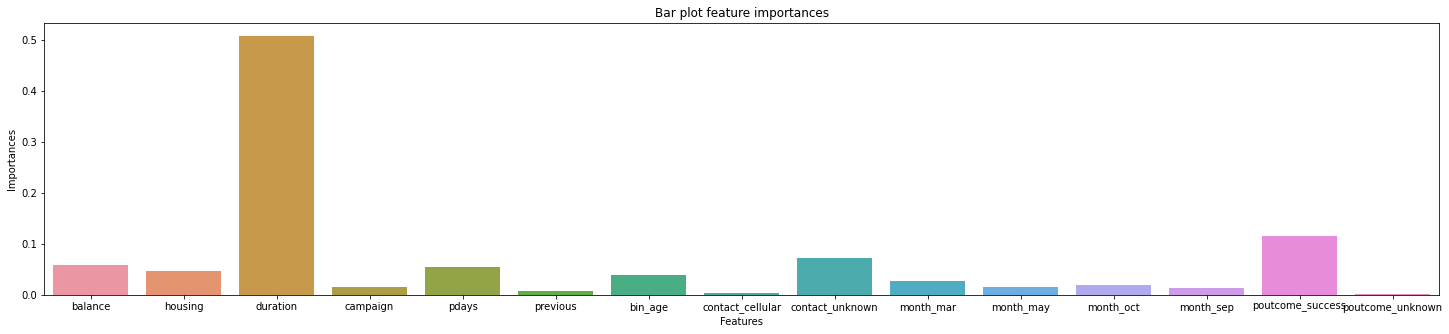

In [1516]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
fig, ax = plt.subplots(figsize=(25, 5)) #фигура + координатная плоскость
feature = X.columns #признаки
feature_importances = gb.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');


Feature: 0, Score: 0.05795
Feature: 1, Score: 0.04773
Feature: 2, Score: 0.50711
Feature: 3, Score: 0.01478
Feature: 4, Score: 0.05508
Feature: 5, Score: 0.00845
Feature: 6, Score: 0.03990
Feature: 7, Score: 0.00362
Feature: 8, Score: 0.07258
Feature: 9, Score: 0.02782
Feature: 10, Score: 0.01521
Feature: 11, Score: 0.01988
Feature: 12, Score: 0.01353
Feature: 13, Score: 0.11496
Feature: 14, Score: 0.00141


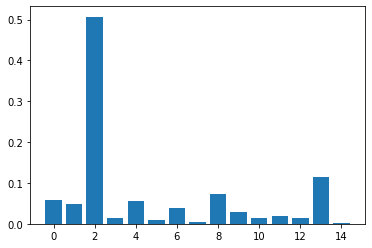

In [1517]:
import matplotlib.pyplot  as plt
importance = gb.feature_importances_
for i,v in enumerate(importance):
  print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Задания 6,7,8

In [1518]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

study = optuna.create_study()

study.optimize(optuna_rf, n_trials=20)
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)

print("accuracy на тестовом наборе: {:.3f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2022-09-19 21:08:06,415] A new study created in memory with name: no-name-d0fa6012-2bc6-4c09-9320-b469adb22f94
[I 2022-09-19 21:08:07,410] Trial 0 finished with value: 0.8605739238927013 and parameters: {'n_estimators': 172, 'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8605739238927013.
[I 2022-09-19 21:08:08,306] Trial 1 finished with value: 0.8461659087345146 and parameters: {'n_estimators': 199, 'max_depth': 23, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8461659087345146.
[I 2022-09-19 21:08:08,889] Trial 2 finished with value: 0.8564294631710362 and parameters: {'n_estimators': 119, 'max_depth': 18, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8461659087345146.
[I 2022-09-19 21:08:09,785] Trial 3 finished with value: 0.867270455965022 and parameters: {'n_estimators': 179, 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8461659087345146.
[I 2022-09-19 21:08:10,570] Trial 4 finished with value: 0.846214140147358

accuracy на тестовом наборе: 0.823
f1_score на тестовом наборе: 0.812
